In [1]:
import gc
import os
import sys
import warnings
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import resnet10t, resnet34d
from torch.cuda import amp
from tqdm import tqdm
from einops import rearrange


In [2]:
sys.path.append('/kaggle/working/notebook/experiment/stacked_unet')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/24-39/"
    dataset_range = train_dataset_path.split("/")[-2]

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============

    z_start = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[0])
    z_end = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[1])
    in_chans = z_end-z_start+1
    crop_depth = 6
    random_shift = random.randint(0, 4)
    layer_shift = [0, 2, 4, 6]
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size //2

    train_batch_size = 64  # 32
    valid_batch_size = train_batch_size

    epochs = 25  # 15

    lr = 1e-4
    loss = "bce_dice_loss"


    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


### Load data

In [4]:
def preprocess(image, fragment_i, split_i):
    return image



len(train_images) = 11194
train_images[0].shape = (256, 256, 16)
train_labels[0].shape = (256, 256, 1)
train_masks[0].shape = (256, 256, 1)

len(valid_images) = 3087
valid_images[0].shape = (256, 256, 16)
valid_labels[0].shape = (256, 256, 1)



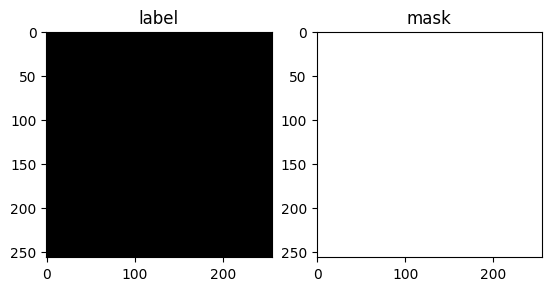

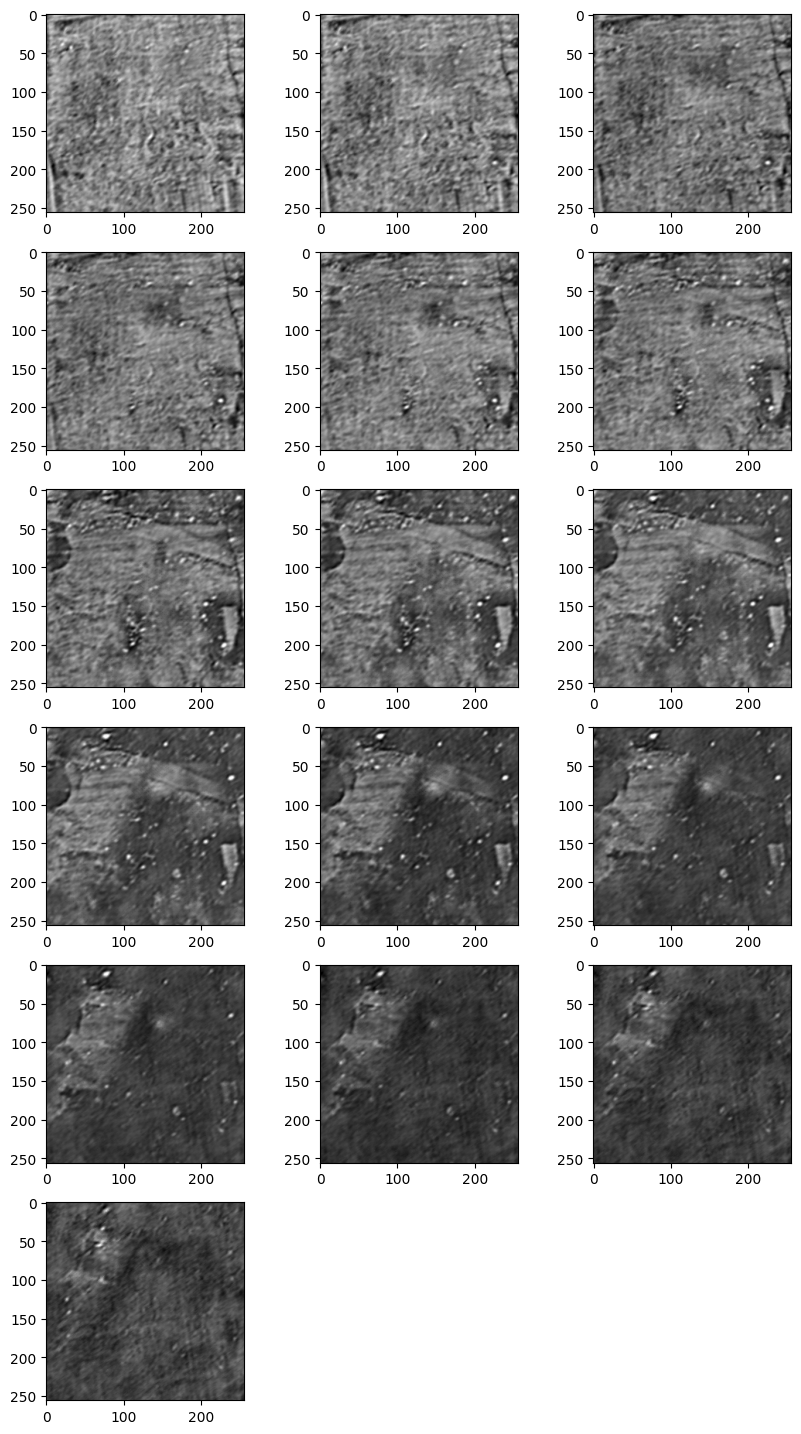

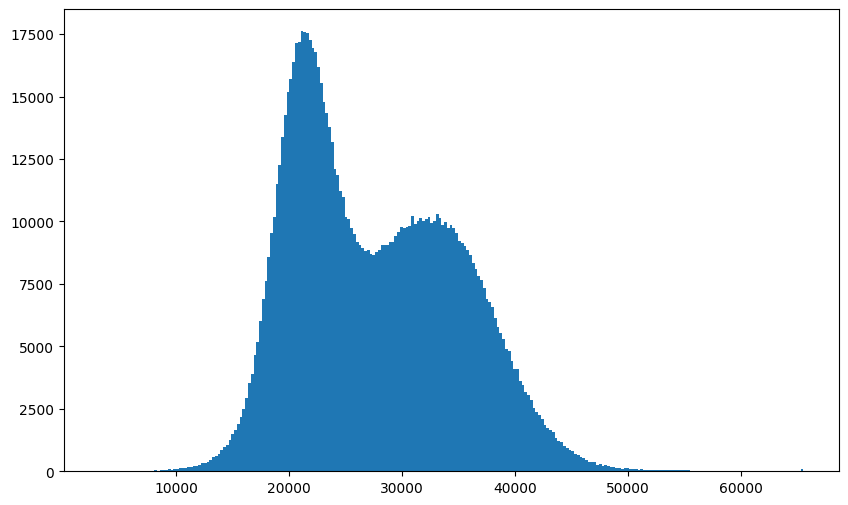

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


### Model

In [6]:
class SmpUnetDecoder(nn.Module):
	def __init__(self,
	         in_channel,
	         skip_channel,
	         out_channel,
	    ):
		super().__init__()
		self.center = nn.Identity()

		i_channel = [in_channel,]+ out_channel[:-1]
		s_channel = skip_channel
		o_channel = out_channel
		block = [
			DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
			for i, s, o in zip(i_channel, s_channel, o_channel)
		]
		self.block = nn.ModuleList(block)

	def forward(self, feature, skip):
		d = self.center(feature)
		decode = []
		for i, block in enumerate(self.block):
			s = skip[i]
			d = block(d, s)
			decode.append(d)

		last  = d
		return last, decode

class Net(nn.Module):
	def __init__(self,):
		super().__init__()
		self.output_type = ['inference', 'loss']

		conv_dim = 64
		encoder1_dim  = [conv_dim, 64, 128, 256, 512, ]
		decoder1_dim  = [256, 128, 64, 64,]

		self.encoder1 = resnet34d(pretrained=True, in_chans=CFG.crop_depth)

		self.decoder1 = SmpUnetDecoder(
			in_channel   = encoder1_dim[-1],
			skip_channel = encoder1_dim[:-1][::-1],
			out_channel  = decoder1_dim,
		)
		# -- pool attention weight
		self.weight1 = nn.ModuleList([
			nn.Sequential(
				nn.Conv2d(dim, dim, kernel_size=3, padding=1),
				nn.ReLU(inplace=True),
			) for dim in encoder1_dim
		])
		self.logit1 = nn.Conv2d(decoder1_dim[-1],1,kernel_size=1)

		#--------------------------------
		#
		encoder2_dim  = [64, 128, 256, 512]
		decoder2_dim  = [128, 64, 32, ]
		self.encoder2 = resnet10t(pretrained=True, in_chans=decoder1_dim[-1])
		

		self.decoder2 = SmpUnetDecoder(
			in_channel   = encoder2_dim[-1],
			skip_channel = encoder2_dim[:-1][::-1],
			out_channel  = decoder2_dim,
		)
		self.logit2 = nn.Conv2d(decoder2_dim[-1],1,kernel_size=1)

	def forward(self, batch):
		v = batch
		B,C,H,W = v.shape
		random_shift = CFG.random_shift
		vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
		]
		K = len(vv)
		x = torch.cat(vv,0)
		#x = v

		#----------------------
		encoder = []
		e = self.encoder1
		x = e.conv1(x)
		x = e.bn1(x)
		x = e.act1(x);
		encoder.append(x)
		x = F.avg_pool2d(x, kernel_size=2, stride=2)
		x = e.layer1(x);
		encoder.append(x)
		x = e.layer2(x);
		encoder.append(x)
		x = e.layer3(x);
		encoder.append(x)
		x = e.layer4(x);
		encoder.append(x)
		# print('encoder', [f.shape for f in encoder])

		for i in range(len(encoder)):
			e = encoder[i]
			f = self.weight1[i](e)
			_, c, h, w = e.shape
			f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
			e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
			w = F.softmax(f, 1)
			e = (w * e).sum(1)
			encoder[i] = e

		feature = encoder[-1]
		skip = encoder[:-1][::-1]
		last, decoder = self.decoder1(feature, skip)
		logit1 = self.logit1(last)

		#----------------------
		x = last #.detach()
		#x = F.avg_pool2d(x,kernel_size=2,stride=2)
		encoder = []
		e = self.encoder2
		x = e.layer1(x); encoder.append(x)
		x = e.layer2(x); encoder.append(x)
		x = e.layer3(x); encoder.append(x)
		x = e.layer4(x); encoder.append(x)

		feature = encoder[-1]
		skip = encoder[:-1][::-1]
		last, decoder = self.decoder2(feature, skip)
		logit2 = self.logit2(last)
		logit1 = F.interpolate(logit1, size=(H
                                       , W), mode='bilinear', align_corners=False, antialias=True)
		logit2 = F.interpolate(logit2, size=(H
                                       , W), mode='bilinear', align_corners=False, antialias=True)

		return logit1, logit2


### Training

In [7]:
for fold_i, fold in enumerate(glob(f"{CFG.train_dataset_path}/*")):
    fold = os.path.basename(fold).split(".")[0]
    valid_fragment_i = int(fold.split("_")[0])
    valid_split_i = int(fold.split("_")[1])
    print(f"fold: {fold_i}")

    train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess, "inklabels")

    dataloader_train, dataloader_valid = generate_dataloader(train_images, train_labels,  valid_images, valid_labels, valid_xyxys, CFG)

    n_train = len(dataloader_train)
    n_valid = len(dataloader_valid)

    gt_mask = generate_valid_label(valid_fragment_i, valid_split_i, CFG, "inklabels")
    gt_shape = gt_mask.shape


    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))

    model = Net()
    model = nn.DataParallel(model, device_ids=device_ids)
    model = model.cuda()

    scaler = amp.GradScaler()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    fbeta = 0

    for epoch in range(CFG.epochs):
        model.train()
        cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        mloss_train, mloss_val = 0.0, 0.0

        for i, (fragments, masks) in pbar_train:
            fragments, masks = fragments.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():  # type: ignore
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                scaler.scale(loss).backward()# type: ignore
                scaler.step(optimizer)
                scaler.update()
                mloss_train += loss.detach().item()

            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, cur_lr,
                                                                  f"Loss: {mloss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')  # type: ignore
        final_pred_count = torch.zeros(gt_shape)

        for i, (fragments, masks, xys) in pbar_val:
            fragments, masks = fragments.cuda(), masks.cuda()
            with torch.no_grad():
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                mloss_val += loss.detach().item()
                pred_masks = torch.sigmoid(logit2)

            for j, xy in enumerate(xys):
                final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] += pred_masks[j, 0]
                final_pred_count[xy[1]:xy[3], xy[0]:xy[2]] += np.ones((CFG.size, CFG.size))

            pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        final_pred_mask = final_pred_mask.cpu()
        final_pred_mask /= final_pred_count

        fbeta_ = fbeta_score(final_pred_mask, gt_mask, 0.5)
        print(f"FBeta : {fbeta_:.4f}\tSAVED MODEL\n" if fbeta_ > fbeta else f"FBeta : {fbeta_:.4f}\n")
        if fbeta_ > fbeta:
            fbeta = fbeta_
            model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold_i}.pth'
            torch.save({'model': model.module.state_dict(),
                        'preds': final_pred_mask.numpy()},
                       model_path)

    del model
    gc.collect()
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify


fold: 0


Epoch 0/25  Mem : 22.3GB  LR : 1.00E-04  Loss: 0.9691: 100%|██████████| 174/174 
Val Loss: 0.7342: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]               


FBeta : 0.3790	SAVED MODEL



Epoch 1/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.5918: 100%|██████████| 174/174 
Val Loss: 0.5023: 100%|██████████| 49/49 [00:14<00:00,  3.40it/s]               


FBeta : 0.4668	SAVED MODEL



Epoch 2/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4848: 100%|██████████| 174/174 
Val Loss: 0.4977: 100%|██████████| 49/49 [00:14<00:00,  3.46it/s]               


FBeta : 0.2415



Epoch 3/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4492: 100%|██████████| 174/174 
Val Loss: 0.6527: 100%|██████████| 49/49 [00:14<00:00,  3.43it/s]               


FBeta : 0.0752



Epoch 4/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4316: 100%|██████████| 174/174 
Val Loss: 0.4723: 100%|██████████| 49/49 [00:14<00:00,  3.46it/s]               


FBeta : 0.4798	SAVED MODEL



Epoch 5/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4116: 100%|██████████| 174/174 
Val Loss: 1.1053: 100%|██████████| 49/49 [00:14<00:00,  3.45it/s]               


FBeta : 0.3240



Epoch 6/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4029: 100%|██████████| 174/174 
Val Loss: 0.5418: 100%|██████████| 49/49 [00:14<00:00,  3.43it/s]               


FBeta : 0.4761



Epoch 7/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3905: 100%|██████████| 174/174 
Val Loss: 0.5427: 100%|██████████| 49/49 [00:14<00:00,  3.45it/s]               


FBeta : 0.4031



Epoch 8/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3812: 100%|██████████| 174/174 
Val Loss: 0.5494: 100%|██████████| 49/49 [00:14<00:00,  3.46it/s]               


FBeta : 0.4210



Epoch 9/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3685: 100%|██████████| 174/174 
Val Loss: 0.4256: 100%|██████████| 49/49 [00:14<00:00,  3.46it/s]               


FBeta : 0.5817	SAVED MODEL



Epoch 10/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3592: 100%|██████████| 174/174
Val Loss: 0.5088: 100%|██████████| 49/49 [00:14<00:00,  3.45it/s]               


FBeta : 0.4264



Epoch 11/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3488: 100%|██████████| 174/174
Val Loss: 0.4870: 100%|██████████| 49/49 [00:14<00:00,  3.45it/s]               


FBeta : 0.4716



Epoch 12/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3400: 100%|██████████| 174/174
Val Loss: 0.4393: 100%|██████████| 49/49 [00:14<00:00,  3.44it/s]               


FBeta : 0.5648



Epoch 13/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3332: 100%|██████████| 174/174
Val Loss: 0.4502: 100%|██████████| 49/49 [00:14<00:00,  3.44it/s]               


FBeta : 0.5787



Epoch 14/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3211: 100%|██████████| 174/174
Val Loss: 0.5619: 100%|██████████| 49/49 [00:14<00:00,  3.45it/s]               


FBeta : 0.4574



Epoch 15/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3130: 100%|██████████| 174/174
Val Loss: 0.6414: 100%|██████████| 49/49 [00:14<00:00,  3.46it/s]               


FBeta : 0.4204



Epoch 16/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3020: 100%|██████████| 174/174
Val Loss: 0.4739: 100%|██████████| 49/49 [00:14<00:00,  3.45it/s]               


FBeta : 0.5400



Epoch 17/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2959: 100%|██████████| 174/174
Val Loss: 0.4505: 100%|██████████| 49/49 [00:14<00:00,  3.44it/s]               


FBeta : 0.5745



Epoch 18/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2877: 100%|██████████| 174/174
Val Loss: 0.4698: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]               


FBeta : 0.6103	SAVED MODEL



Epoch 19/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2786: 100%|██████████| 174/174
Val Loss: 0.4731: 100%|██████████| 49/49 [00:14<00:00,  3.44it/s]               


FBeta : 0.5690



Epoch 20/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2678: 100%|██████████| 174/174
Val Loss: 0.4748: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]               


FBeta : 0.5814



Epoch 21/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2623: 100%|██████████| 174/174
Val Loss: 0.4518: 100%|██████████| 49/49 [00:14<00:00,  3.43it/s]               


FBeta : 0.5760



Epoch 22/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2585: 100%|██████████| 174/174
Val Loss: 0.4627: 100%|██████████| 49/49 [00:14<00:00,  3.46it/s]               


FBeta : 0.5878



Epoch 23/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2500: 100%|██████████| 174/174
Val Loss: 0.4872: 100%|██████████| 49/49 [00:14<00:00,  3.43it/s]               


FBeta : 0.5698



Epoch 24/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2454: 100%|██████████| 174/174
Val Loss: 0.5008: 100%|██████████| 49/49 [00:14<00:00,  3.44it/s]               


FBeta : 0.5898

fold: 1


Epoch 0/25  Mem : 22.3GB  LR : 1.00E-04  Loss: 1.0735: 100%|██████████| 177/177 
Val Loss: 0.7332: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.3208	SAVED MODEL



Epoch 1/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.6852: 100%|██████████| 177/177 
Val Loss: 0.4009: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.2338



Epoch 2/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.5637: 100%|██████████| 177/177 
Val Loss: 0.4767: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.2959



Epoch 3/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.5197: 100%|██████████| 177/177 
Val Loss: 0.2938: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]               


FBeta : 0.2757



Epoch 4/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4983: 100%|██████████| 177/177 
Val Loss: 0.2877: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.5081	SAVED MODEL



Epoch 5/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4761: 100%|██████████| 177/177 
Val Loss: 0.2992: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.4046



Epoch 6/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4606: 100%|██████████| 177/177 
Val Loss: 0.2680: 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]               


FBeta : 0.4741



Epoch 7/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4507: 100%|██████████| 177/177 
Val Loss: 0.3226: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.4509



Epoch 8/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4349: 100%|██████████| 177/177 
Val Loss: 0.3506: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]               


FBeta : 0.4246



Epoch 9/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4234: 100%|██████████| 177/177 
Val Loss: 0.2658: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.5598	SAVED MODEL



Epoch 10/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4138: 100%|██████████| 177/177
Val Loss: 0.2684: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5922	SAVED MODEL



Epoch 11/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3992: 100%|██████████| 177/177
Val Loss: 0.2544: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.6033	SAVED MODEL



Epoch 12/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3910: 100%|██████████| 177/177
Val Loss: 0.2537: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]               


FBeta : 0.5737



Epoch 13/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3780: 100%|██████████| 177/177
Val Loss: 0.2600: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5709



Epoch 14/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3745: 100%|██████████| 177/177
Val Loss: 0.2775: 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]               


FBeta : 0.5652



Epoch 15/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3603: 100%|██████████| 177/177
Val Loss: 0.2719: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5577



Epoch 16/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3460: 100%|██████████| 177/177
Val Loss: 0.2609: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5801



Epoch 17/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3391: 100%|██████████| 177/177
Val Loss: 0.2673: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.6070	SAVED MODEL



Epoch 18/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3316: 100%|██████████| 177/177
Val Loss: 0.2531: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6063



Epoch 19/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3179: 100%|██████████| 177/177
Val Loss: 0.2837: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.5367



Epoch 20/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3088: 100%|██████████| 177/177
Val Loss: 0.2646: 100%|██████████| 46/46 [00:13<00:00,  3.33it/s]               


FBeta : 0.6144	SAVED MODEL



Epoch 21/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3027: 100%|██████████| 177/177
Val Loss: 0.2719: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.6026



Epoch 22/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2960: 100%|██████████| 177/177
Val Loss: 0.2791: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.6127



Epoch 23/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2870: 100%|██████████| 177/177
Val Loss: 0.2750: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.6068



Epoch 24/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2827: 100%|██████████| 177/177
Val Loss: 0.2714: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.6199	SAVED MODEL

fold: 2


Epoch 0/25  Mem : 22.3GB  LR : 1.00E-04  Loss: 0.9981: 100%|██████████| 177/177 
Val Loss: 0.9261: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.2957	SAVED MODEL



Epoch 1/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.5731: 100%|██████████| 177/177 
Val Loss: 0.7295: 100%|██████████| 46/46 [00:13<00:00,  3.33it/s]               


FBeta : 0.3883	SAVED MODEL



Epoch 2/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4565: 100%|██████████| 177/177 
Val Loss: 0.6717: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.4633	SAVED MODEL



Epoch 3/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4213: 100%|██████████| 177/177 
Val Loss: 0.6763: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.5094	SAVED MODEL



Epoch 4/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3997: 100%|██████████| 177/177 
Val Loss: 0.6265: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.5549	SAVED MODEL



Epoch 5/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3848: 100%|██████████| 177/177 
Val Loss: 0.6812: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.5660	SAVED MODEL



Epoch 6/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3711: 100%|██████████| 177/177 
Val Loss: 0.6666: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.4680



Epoch 7/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3630: 100%|██████████| 177/177 
Val Loss: 0.6860: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.5075



Epoch 8/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3518: 100%|██████████| 177/177 
Val Loss: 0.5869: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.5632



Epoch 9/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3410: 100%|██████████| 177/177 
Val Loss: 0.6293: 100%|██████████| 46/46 [00:13<00:00,  3.33it/s]               


FBeta : 0.5207



Epoch 10/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3358: 100%|██████████| 177/177
Val Loss: 0.7036: 100%|██████████| 46/46 [00:13<00:00,  3.29it/s]               


FBeta : 0.4939



Epoch 11/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3237: 100%|██████████| 177/177
Val Loss: 0.7392: 100%|██████████| 46/46 [00:13<00:00,  3.32it/s]               


FBeta : 0.5141



Epoch 12/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3184: 100%|██████████| 177/177
Val Loss: 0.6606: 100%|██████████| 46/46 [00:13<00:00,  3.31it/s]               


FBeta : 0.5851	SAVED MODEL



Epoch 13/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3123: 100%|██████████| 177/177
Val Loss: 0.7594: 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]               


FBeta : 0.5514



Epoch 14/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3020: 100%|██████████| 177/177
Val Loss: 0.7470: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.4816



Epoch 15/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2929: 100%|██████████| 177/177
Val Loss: 0.5907: 100%|██████████| 46/46 [00:13<00:00,  3.32it/s]               


FBeta : 0.6042	SAVED MODEL



Epoch 16/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2893: 100%|██████████| 177/177
Val Loss: 0.6555: 100%|██████████| 46/46 [00:13<00:00,  3.30it/s]               


FBeta : 0.6082	SAVED MODEL



Epoch 17/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2783: 100%|██████████| 177/177
Val Loss: 0.6687: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.6223	SAVED MODEL



Epoch 18/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2736: 100%|██████████| 177/177
Val Loss: 0.6313: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.6223	SAVED MODEL



Epoch 19/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2630: 100%|██████████| 177/177
Val Loss: 0.6583: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.6315	SAVED MODEL



Epoch 20/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2593: 100%|██████████| 177/177
Val Loss: 0.6501: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.6463	SAVED MODEL



Epoch 21/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2518: 100%|██████████| 177/177
Val Loss: 0.6442: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.6461



Epoch 22/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2440: 100%|██████████| 177/177
Val Loss: 0.6171: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.6620	SAVED MODEL



Epoch 23/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2408: 100%|██████████| 177/177
Val Loss: 0.6383: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.6660	SAVED MODEL



Epoch 24/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2385: 100%|██████████| 177/177
Val Loss: 0.6316: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.6665	SAVED MODEL

fold: 3


Epoch 0/25  Mem : 22.3GB  LR : 1.00E-04  Loss: 1.1894: 100%|██████████| 177/177 
Val Loss: 1.0463: 100%|██████████| 46/46 [00:13<00:00,  3.35it/s]               


FBeta : 0.3907	SAVED MODEL



Epoch 1/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.6689: 100%|██████████| 177/177 
Val Loss: 0.7165: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.0072



Epoch 2/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4761: 100%|██████████| 177/177 
Val Loss: 0.6711: 100%|██████████| 46/46 [00:13<00:00,  3.36it/s]               


FBeta : 0.4193	SAVED MODEL



Epoch 3/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4332: 100%|██████████| 177/177 
Val Loss: 0.6678: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.5065	SAVED MODEL



Epoch 4/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4092: 100%|██████████| 177/177 
Val Loss: 0.5920: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.5239	SAVED MODEL



Epoch 5/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3964: 100%|██████████| 177/177 
Val Loss: 0.6274: 100%|██████████| 46/46 [00:13<00:00,  3.39it/s]               


FBeta : 0.2758



Epoch 6/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3864: 100%|██████████| 177/177 
Val Loss: 0.6178: 100%|██████████| 46/46 [00:13<00:00,  3.36it/s]               


FBeta : 0.5436	SAVED MODEL



Epoch 7/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3720: 100%|██████████| 177/177 
Val Loss: 0.6746: 100%|██████████| 46/46 [00:13<00:00,  3.37it/s]               


FBeta : 0.3612



Epoch 8/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3623: 100%|██████████| 177/177 
Val Loss: 0.5583: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.5932	SAVED MODEL



Epoch 9/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3498: 100%|██████████| 177/177 
Val Loss: 0.5715: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.6028	SAVED MODEL



Epoch 10/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3433: 100%|██████████| 177/177
Val Loss: 0.6770: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.5144



Epoch 11/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3362: 100%|██████████| 177/177
Val Loss: 0.5225: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.6618	SAVED MODEL



Epoch 12/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3256: 100%|██████████| 177/177
Val Loss: 0.5337: 100%|██████████| 46/46 [00:13<00:00,  3.37it/s]               


FBeta : 0.6610



Epoch 13/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3181: 100%|██████████| 177/177
Val Loss: 0.6034: 100%|██████████| 46/46 [00:13<00:00,  3.36it/s]               


FBeta : 0.5689



Epoch 14/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3090: 100%|██████████| 177/177
Val Loss: 0.5842: 100%|██████████| 46/46 [00:13<00:00,  3.40it/s]               


FBeta : 0.6207



Epoch 15/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2994: 100%|██████████| 177/177
Val Loss: 0.6160: 100%|██████████| 46/46 [00:13<00:00,  3.36it/s]               


FBeta : 0.5743



Epoch 16/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2951: 100%|██████████| 177/177
Val Loss: 0.5062: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.6983	SAVED MODEL



Epoch 17/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2837: 100%|██████████| 177/177
Val Loss: 0.5288: 100%|██████████| 46/46 [00:13<00:00,  3.37it/s]               


FBeta : 0.6857



Epoch 18/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2755: 100%|██████████| 177/177
Val Loss: 0.5298: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]               


FBeta : 0.7063	SAVED MODEL



Epoch 19/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2647: 100%|██████████| 177/177
Val Loss: 0.5211: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.6975



Epoch 20/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2596: 100%|██████████| 177/177
Val Loss: 0.5005: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.7072	SAVED MODEL



Epoch 21/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2556: 100%|██████████| 177/177
Val Loss: 0.5191: 100%|██████████| 46/46 [00:13<00:00,  3.29it/s]               


FBeta : 0.6900



Epoch 22/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2447: 100%|██████████| 177/177
Val Loss: 0.5270: 100%|██████████| 46/46 [00:13<00:00,  3.38it/s]               


FBeta : 0.6922



Epoch 23/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2421: 100%|██████████| 177/177
Val Loss: 0.5396: 100%|██████████| 46/46 [00:13<00:00,  3.30it/s]               


FBeta : 0.6856



Epoch 24/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2383: 100%|██████████| 177/177
Val Loss: 0.5404: 100%|██████████| 46/46 [00:13<00:00,  3.37it/s]               


FBeta : 0.6850

fold: 4


Epoch 0/25  Mem : 22.3GB  LR : 1.00E-04  Loss: 1.1537: 100%|██████████| 185/185 
Val Loss: 0.9211: 100%|██████████| 38/38 [00:11<00:00,  3.19it/s]               


FBeta : 0.3544	SAVED MODEL



Epoch 1/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.6796: 100%|██████████| 185/185 
Val Loss: 0.5655: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]               


FBeta : 0.3876	SAVED MODEL



Epoch 2/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.5154: 100%|██████████| 185/185 
Val Loss: 0.4509: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]               


FBeta : 0.4309	SAVED MODEL



Epoch 3/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4800: 100%|██████████| 185/185 
Val Loss: 0.3976: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]               


FBeta : 0.2979



Epoch 4/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4526: 100%|██████████| 185/185 
Val Loss: 0.3852: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]               


FBeta : 0.5600	SAVED MODEL



Epoch 5/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4350: 100%|██████████| 185/185 
Val Loss: 0.3852: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]               


FBeta : 0.3013



Epoch 6/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4222: 100%|██████████| 185/185 
Val Loss: 0.3654: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]               


FBeta : 0.5345



Epoch 7/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.4052: 100%|██████████| 185/185 
Val Loss: 0.5155: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]               


FBeta : 0.4247



Epoch 8/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3976: 100%|██████████| 185/185 
Val Loss: 0.3722: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]               


FBeta : 0.5946	SAVED MODEL



Epoch 9/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3881: 100%|██████████| 185/185 
Val Loss: 0.3852: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]               


FBeta : 0.5295



Epoch 10/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3814: 100%|██████████| 185/185
Val Loss: 0.5776: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]               


FBeta : 0.3914



Epoch 11/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3662: 100%|██████████| 185/185
Val Loss: 0.3218: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]               


FBeta : 0.6655	SAVED MODEL



Epoch 12/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3637: 100%|██████████| 185/185
Val Loss: 0.3342: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]               


FBeta : 0.6218



Epoch 13/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3511: 100%|██████████| 185/185
Val Loss: 0.4687: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]               


FBeta : 0.4734



Epoch 14/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3414: 100%|██████████| 185/185
Val Loss: 0.4560: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]               


FBeta : 0.5012



Epoch 15/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3325: 100%|██████████| 185/185
Val Loss: 0.3270: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]               


FBeta : 0.6723	SAVED MODEL



Epoch 16/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3204: 100%|██████████| 185/185
Val Loss: 0.3828: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]               


FBeta : 0.5708



Epoch 17/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.3112: 100%|██████████| 185/185
Val Loss: 0.3388: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]               


FBeta : 0.6127



Epoch 18/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2965: 100%|██████████| 185/185
Val Loss: 0.3252: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]               


FBeta : 0.6421



Epoch 19/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2895: 100%|██████████| 185/185
Val Loss: 0.3613: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]               


FBeta : 0.6321



Epoch 20/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2848: 100%|██████████| 185/185
Val Loss: 0.3298: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]               


FBeta : 0.6387



Epoch 21/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2738: 100%|██████████| 185/185
Val Loss: 0.3313: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]               


FBeta : 0.6538



Epoch 22/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2690: 100%|██████████| 185/185
Val Loss: 0.3321: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]               


FBeta : 0.6538



Epoch 23/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2662: 100%|██████████| 185/185
Val Loss: 0.3397: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]               


FBeta : 0.6313



Epoch 24/25  Mem : 22.3GB  LR : 1.00E-03  Loss: 0.2587: 100%|██████████| 185/185
Val Loss: 0.3451: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]               


FBeta : 0.6148

{"status":200,"message":"ok"}

In [8]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.6103
fbeta: 0.6199
fbeta: 0.6665
fbeta: 0.7072
fbeta: 0.6723


In [9]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.6542


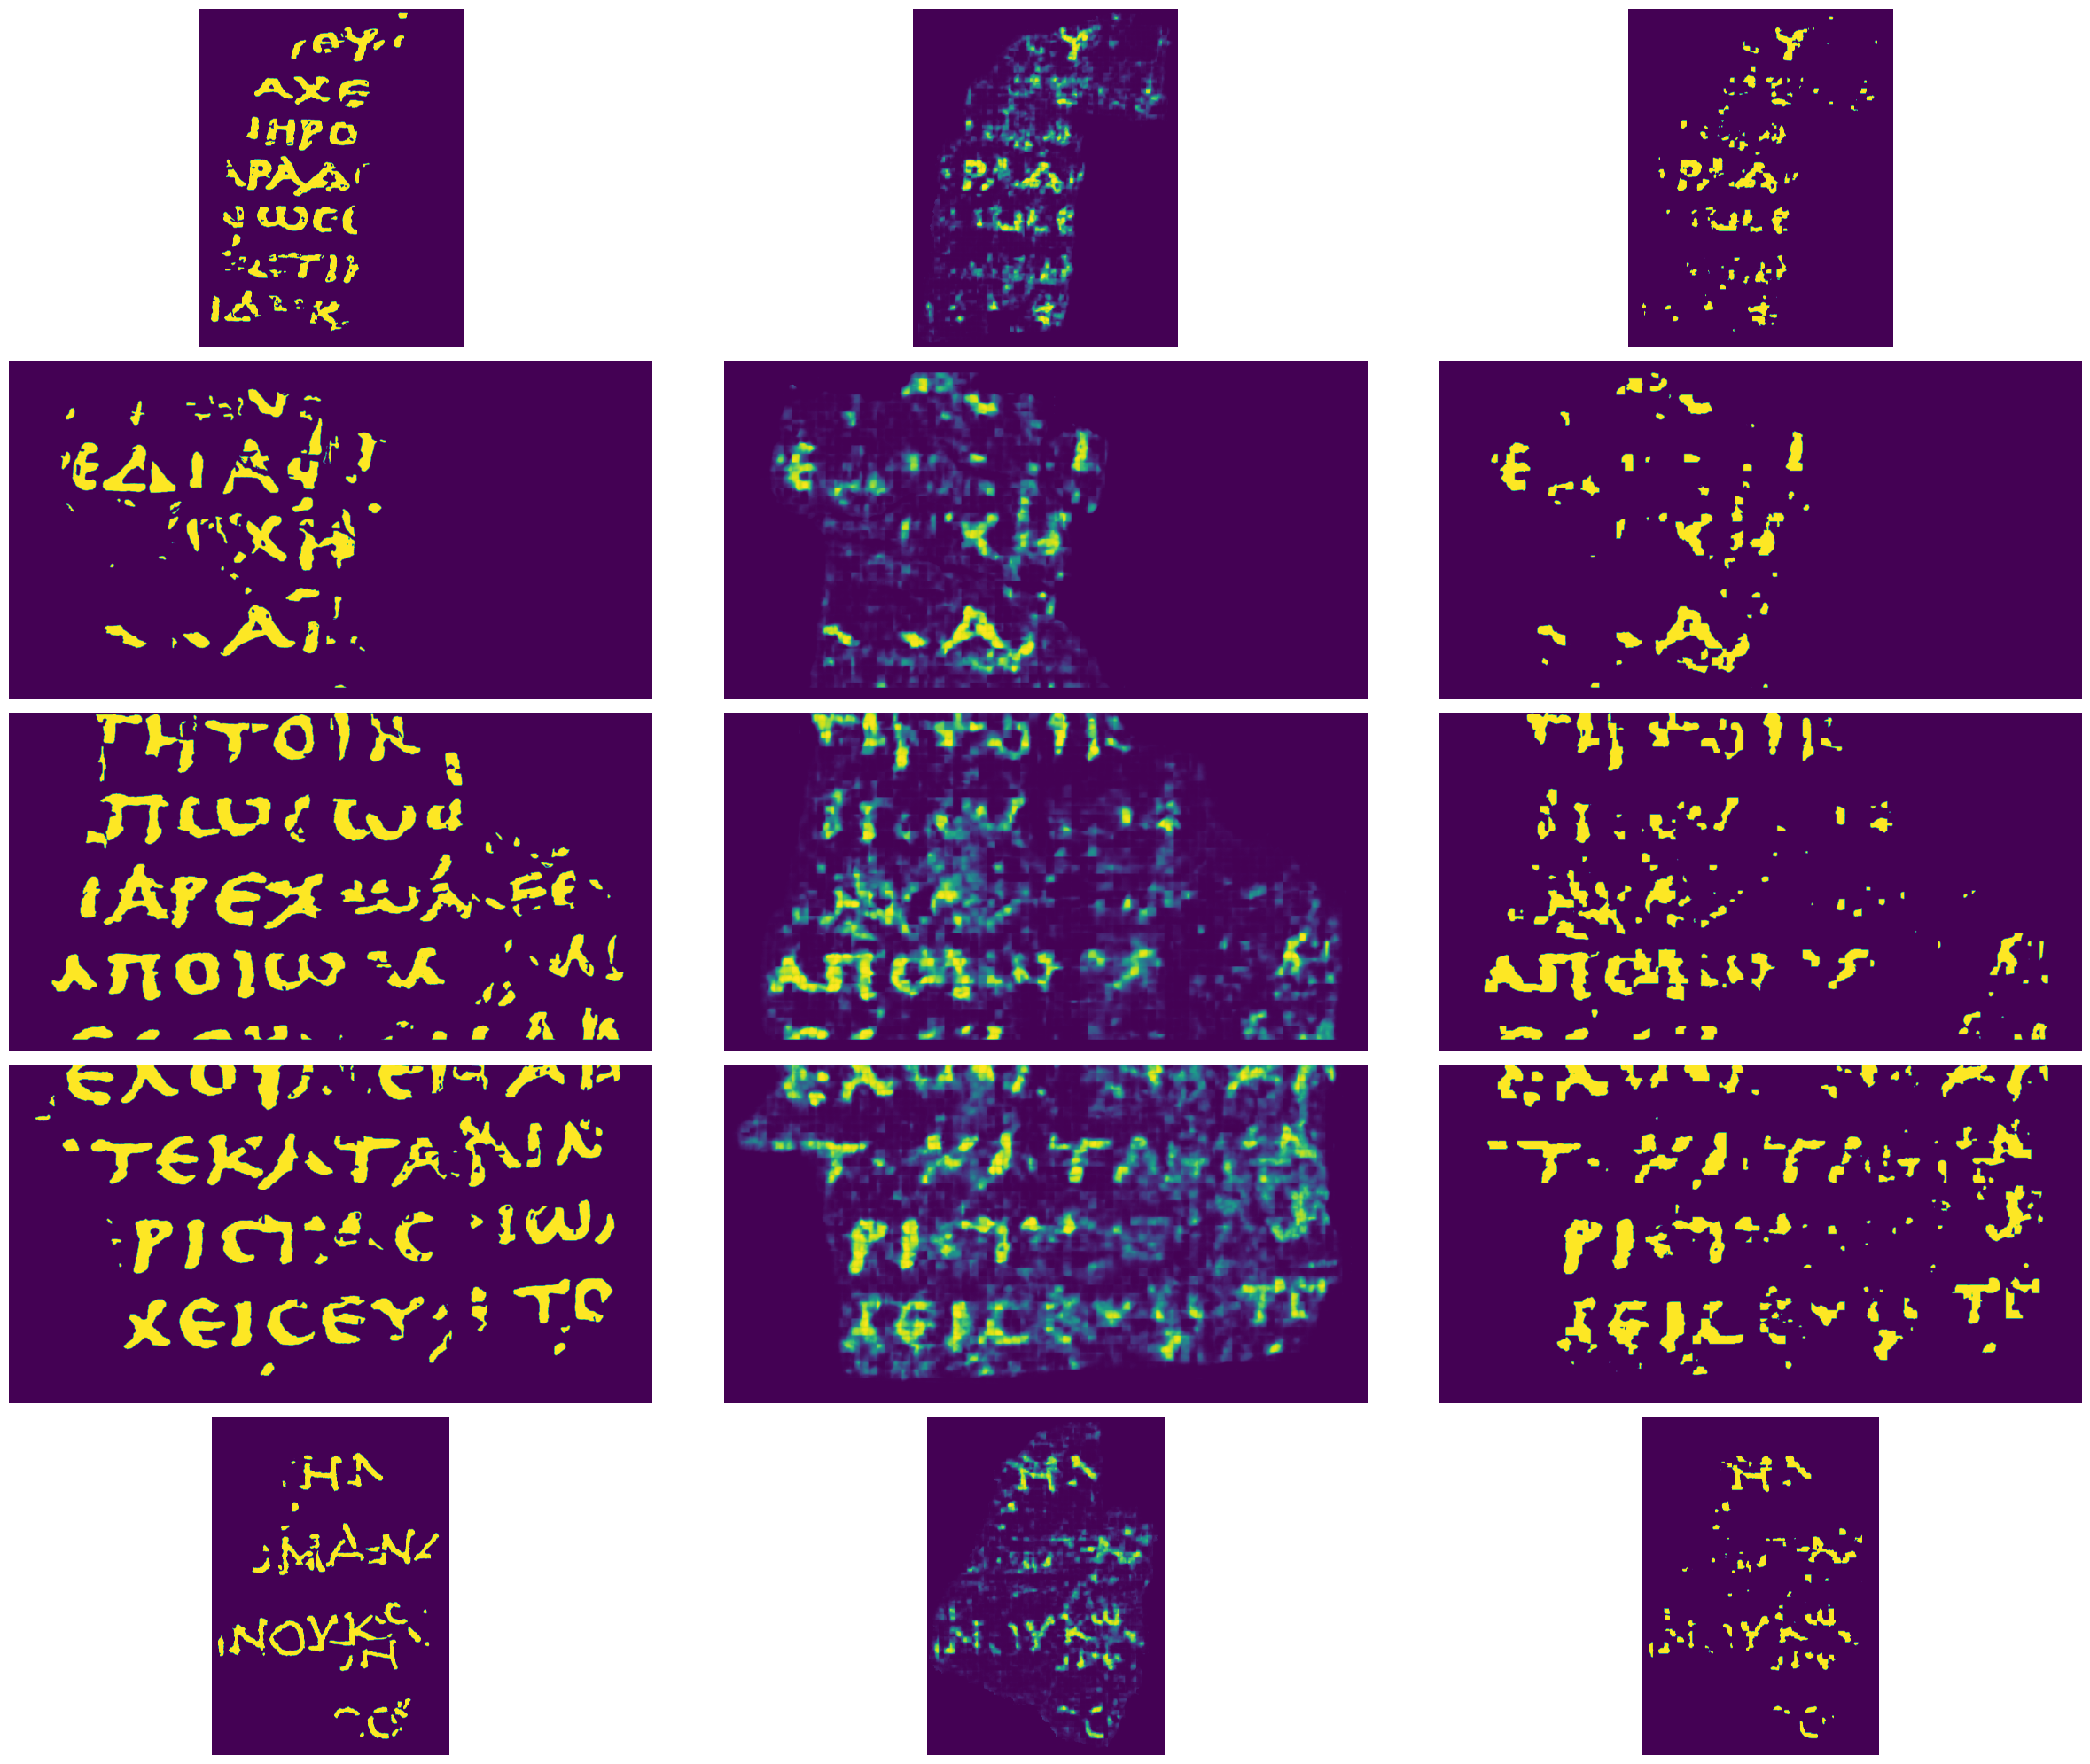

In [10]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)